<a href="https://colab.research.google.com/github/chenlaw/VAES/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

需要的python包

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import nn
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.default_device = 'cuda'
else:
    torch.default_device = 'cpu'

数据和默认参数

In [ ]:
mnist_dataset =torchvision.datasets.MNIST(".",transform=ToTensor(),download=True)
dataLoader = DataLoader(
    mnist_dataset,
    batch_size=100,
    shuffle=True,
)

#默认参数
latent_dim = 2
original_dim =28*28
immediate_dim = 256
epoch = 50

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.84MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



VAE模型

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(original_dim, immediate_dim),
            nn.ReLU()
        )
        self.medium = nn.Linear(immediate_dim, latent_dim)
        self.log_var = nn.Linear(immediate_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, immediate_dim),
            nn.ReLU(),
            nn.Linear(immediate_dim, original_dim),
            nn.Sigmoid()
        )

    def sample(self, n_samples):
        return torch.randn(n_samples, latent_dim)

    def forward(self, input):
        mid = self.encoder(input)
        med = self.medium(mid)
        var = self.log_var(mid)
        std = torch.exp(0.5 * var) + 1e-8  # 修正epsilon位置
        u = self.sample(input.size(0)).to(device) * std + med  # 动态batch size适配
        return self.decoder(u), med, var

    def generate(self, z):
        return self.decoder(z)

In [ ]:
criterion = nn.BCELoss(reduction='sum')


def loss_function(input, output, med, var):
    # 调整输入输出维度适配
    x_loss = criterion(output, input.view(-1, original_dim))

    # 计算KL散度（均值代替求和）
    KL_loss = -0.5 * torch.sum(1 + var - med.pow(2) - var.exp())

    return (x_loss + KL_loss)/2  # 移除人工缩放

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        optimizer.zero_grad()
        X=X.to(device)

        # 前向传播
        recon, med, var = model(X)

        # 计算损失
        loss = loss_fn(X, recon, med, var)

        # 反向传播
        loss.backward()

        # 梯度裁剪防止爆炸
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # 参数更新
        optimizer.step()

        if batch % 100 == 0:
            current = batch * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{len(dataloader.dataset):>5d}]")


In [ ]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # 改用Adam优化器

epochs = 50
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(dataLoader, model, loss_function, optimizer)
print("Done!")

# 保存模型
torch.save(model.state_dict(), "vae_mnist.pth")

Epoch 1
-------------------------------
loss: 27558.556641  [    0/60000]
loss: 9756.928711  [10000/60000]
loss: 9173.337891  [20000/60000]
loss: 8731.300781  [30000/60000]
loss: 8758.790039  [40000/60000]
loss: 8677.389648  [50000/60000]
Epoch 2
-------------------------------
loss: 8603.009766  [    0/60000]
loss: 8611.987305  [10000/60000]
loss: 8383.133789  [20000/60000]
loss: 8627.634766  [30000/60000]
loss: 8156.881348  [40000/60000]
loss: 8104.748535  [50000/60000]
Epoch 3
-------------------------------
loss: 8339.137695  [    0/60000]
loss: 8138.273438  [10000/60000]
loss: 7932.479004  [20000/60000]
loss: 7839.581055  [30000/60000]
loss: 8589.541992  [40000/60000]
loss: 8136.560059  [50000/60000]
Epoch 4
-------------------------------
loss: 8138.820312  [    0/60000]
loss: 7773.876465  [10000/60000]
loss: 8119.705078  [20000/60000]
loss: 8211.324219  [30000/60000]
loss: 8028.455566  [40000/60000]
loss: 8027.893555  [50000/60000]
Epoch 5
-------------------------------
loss: 7

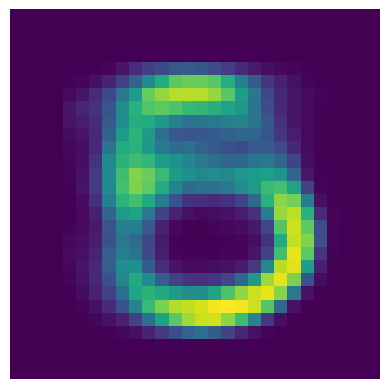

In [ ]:
with torch.no_grad():
    import matplotlib.pyplot as plt

    pic =model.generate(model.sample(1).to(device)).cpu()

# 可视化
    plt.imshow(pic.reshape(28,-1))
    plt.axis('off')  # 不显示坐标轴
    plt.show()